#### 4 analise e exploracao dos dados

In [58]:
import pandas as pd
import numpy as np
import  scipy.signal.signaltools
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)
df = pd.read_csv('./final_df.csv')
df.set_index('Date', inplace=True)
df.head()

df.describe()

,Unnamed: 0,Close,Price
count,5665.000000,5665.000000,5665.000000
mean,2832.000000,54007.688703,2.764041
std,1635.488969,30023.707164,1.010957
min,0.000000,8371.000000,1.538300
25%,1416.000000,26407.000000,1.974200
50%,2832.000000,53947.000000,2.393600
75%,4248.000000,67976.000000,3.271400
max,5664.000000,130776.000000,5.885600


<AxesSubplot:xlabel='Date'>

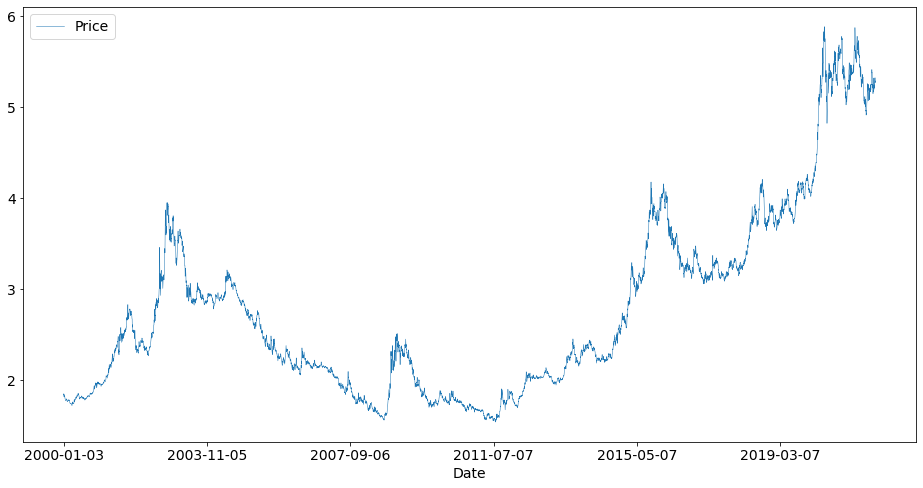

In [59]:
df.index.duplicated().sum()

df.isnull().sum()

df[['Price']].plot.line(linewidth=0.5)



<AxesSubplot:xlabel='Date'>

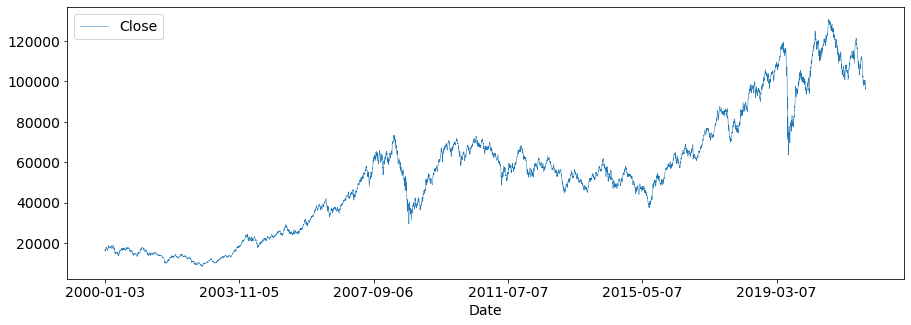

In [60]:
df[['Close']].plot.line(figsize=(15,5), linewidth=0.5)



<AxesSubplot:>

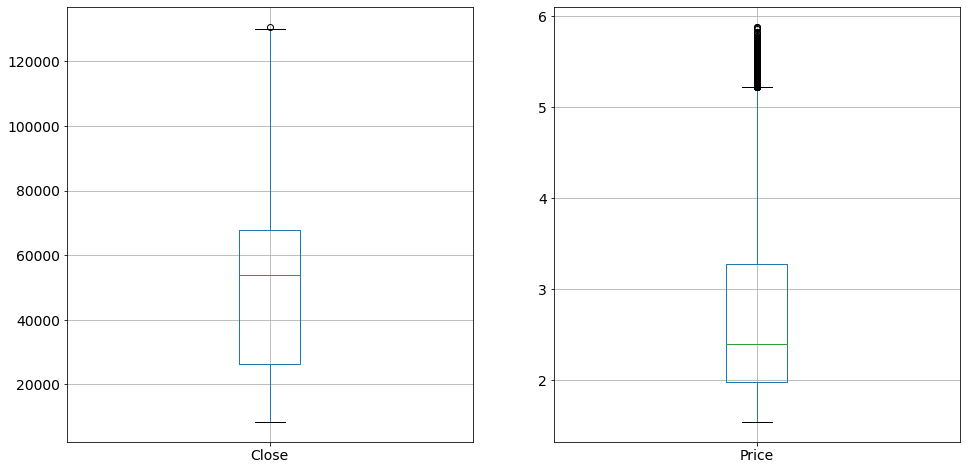

In [61]:
plt.subplot(1, 2, 1)
df.boxplot('Close')
plt.subplot(1, 2, 2)
df.boxplot('Price')


##### 4.1 Featuring Engineering

In [62]:
### Featuring Engineering

#aplicar def
#diferenciação

df.loc[:, "Retorno_dol"] = np.log(df["Price"].div(df["Price"].shift(5)))
#df.loc[:, "Retorno_dol_2"] = df["Retorno_dol"].shift(1)
df.loc[:, "Retorno_ibov"] = np.log(df["Close"].div(df["Close"].shift(5)))
df.loc[:, "Correlacao_dol_ibov"] = (df.loc[:, "Retorno_ibov"].rolling(5).corr(df.loc[:, 'Retorno_dol'])**2)*df.loc[:, "Retorno_dol"]
df.loc[:, "Retorno_ibov"] = df.loc[:, "Retorno_ibov"].shift(-5)
#df = df.dropna().set_index('Date')
df = df.dropna()
df = df[['Retorno_dol','Correlacao_dol_ibov','Retorno_ibov']]
df



,Retorno_dol,Correlacao_dol_ibov,Retorno_ibov
Date,,,
2000-01-14,-0.012942,-0.009732,-0.035978
2000-01-17,-0.011644,-0.006291,-0.061747
2000-01-18,-0.016324,-0.014000,-0.049493
2000-01-19,-0.020722,-0.004108,-0.021114
2000-01-20,-0.016134,-0.001000,-0.005605
...,...,...,...
2021-09-09,0.003025,0.001327,-0.000244
2021-09-10,0.010464,0.003923,-0.008525
2021-09-13,0.008687,0.000891,-0.046836


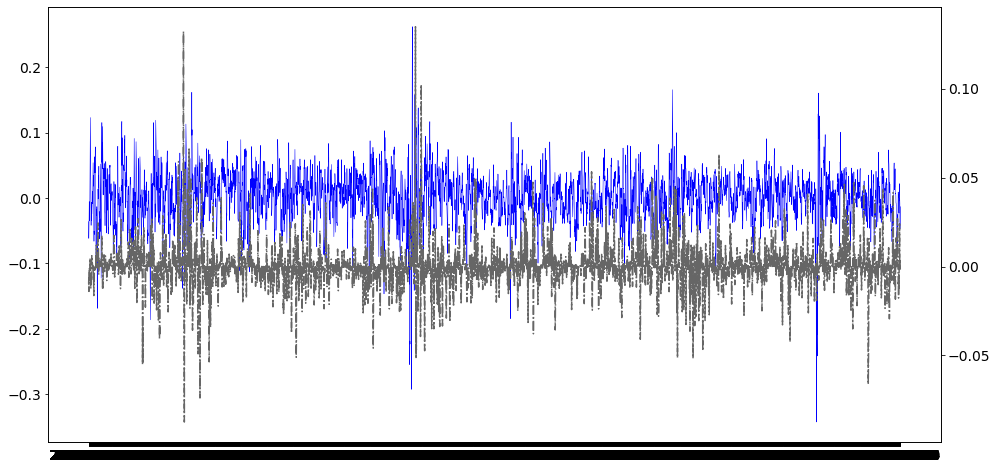

In [63]:
fig, ax1 = plt.subplots()

ax2=ax1.twinx()
ax1.plot(df['Retorno_ibov'],'b',linewidth=0.5)
ax2.plot(df['Correlacao_dol_ibov'],color='#666',ls='-.')



#### 5 modelos de previsao

##### 5.2  Divisão da Base

In [64]:
X = df[['Retorno_dol','Correlacao_dol_ibov']]
y = df['Retorno_ibov']
train_size=int(len(df) * 0.95)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()
train_y.index = pd.DatetimeIndex(train_y.index).to_period('D')
train_X.index = pd.DatetimeIndex(train_X.index).to_period('D')
print(train_X)
print(train_y)
print(test_X)
print(test_y)

            Retorno_dol  Correlacao_dol_ibov
Date                                        
2000-01-14    -0.012942            -0.009732
2000-01-17    -0.011644            -0.006291
2000-01-18    -0.016324            -0.014000
2000-01-19    -0.020722            -0.004108
2000-01-20    -0.016134            -0.001000
...                 ...                  ...
2020-08-10     0.029606             0.005021
2020-08-11     0.016870             0.000231
2020-08-12     0.026691             0.000582
2020-08-13     0.007009             0.000861
2020-08-14    -0.003297            -0.000269

[5368 rows x 2 columns]
Date
2000-01-14   -0.035978
2000-01-17   -0.061747
2000-01-18   -0.049493
2000-01-19   -0.021114
2000-01-20   -0.005605
                ...   
2020-08-10    0.008859
2020-08-11    0.000065
2020-08-12    0.010972
2020-08-13    0.013486
2020-08-14    0.023930
Freq: D, Name: Retorno_ibov, Length: 5368, dtype: float64
            Retorno_dol  Correlacao_dol_ibov
Date                         

##### 5.3 modelo de suavizacao exponencial

{'smoothing_level': 0.9966825669989321, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': -0.03606410114434384, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


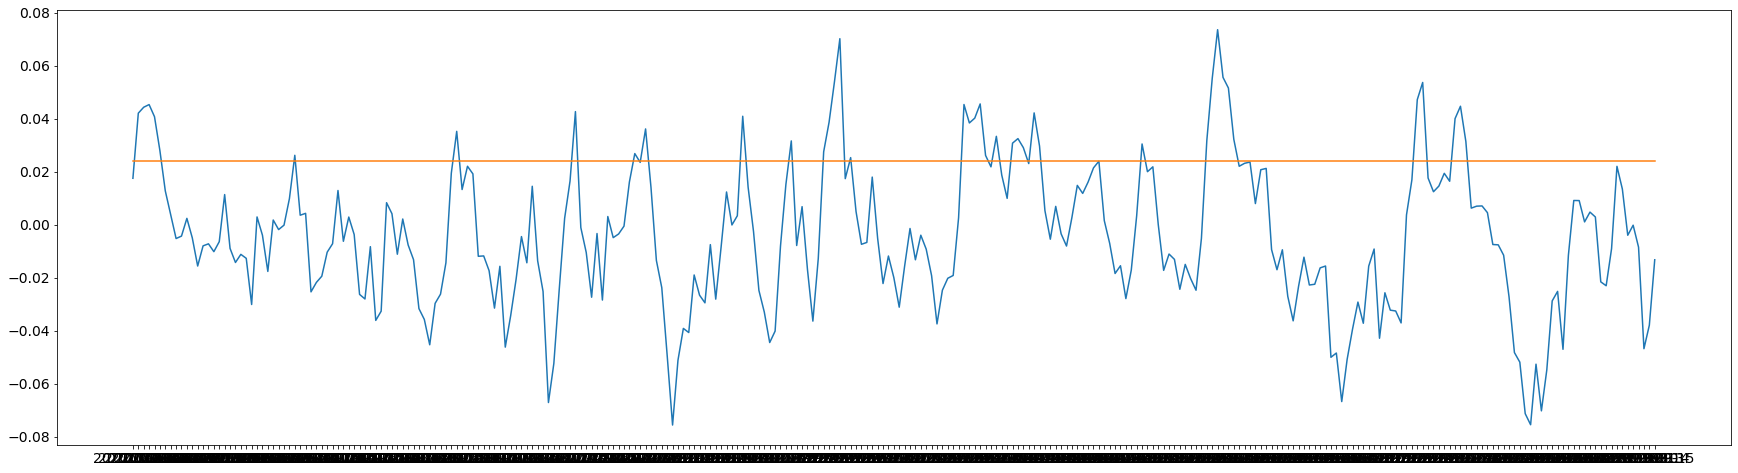

'from sklearn.linear_model import LogisticRegression\nlogreg = LogisticRegression(random_state=0).fit(train_X, (train_y>0).astype(int))\ny_pred = logreg.predict(test_X)'

In [65]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

#Modelo de suavização exponencial

from statsmodels.tsa.api import SimpleExpSmoothing
plt.figure(figsize=(30, 8))
es = SimpleExpSmoothing(train_y) 
es.fit(optimized=True)#,smoothing_level= 0.01) 
print(es.params)
plt.plot(test_y) 
pred_ses = es.predict(es.params, start=len(train_y), end=len(train_y) + len(test_y)-1)
plt.plot(pred_ses) 
plt.show()

pred_ses

'''from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=0).fit(train_X, (train_y>0).astype(int))
y_pred = logreg.predict(test_X)'''



##### 5.3 modelo de suavizacao exponencial holt

{'smoothing_level': 0.9967521925974074, 'smoothing_trend': 5.699018142702956e-19, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': -0.03602030879905003, 'initial_trend': 1.1582763073798256e-05, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


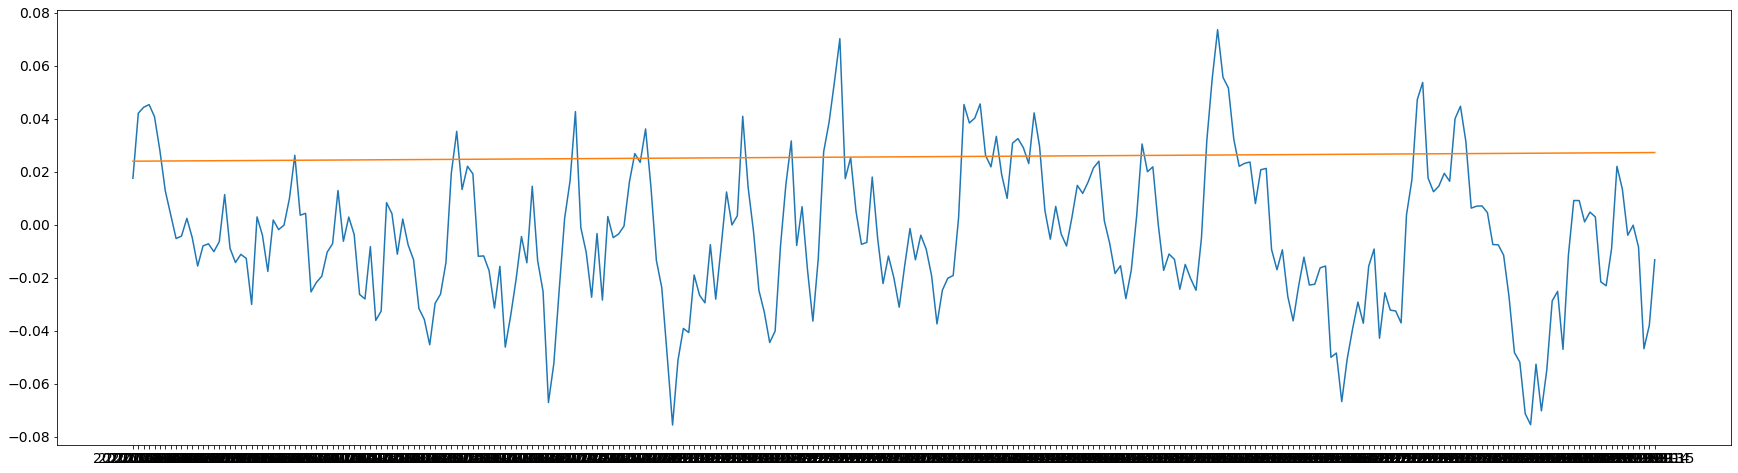

In [66]:
from statsmodels.tsa.api import Holt

plt.figure(figsize=(30, 8))
es_holt = Holt(train_y) 
es_holt.fit(optimized=True)#,smoothing_level= 0.01) 
print(es_holt.params)
plt.plot(test_y) 
pred_holt = es_holt.predict(es_holt.params, start=len(train_y), end=len(train_y) + len(test_y)-1)
plt.plot(pred_holt) 
plt.show()

#### 6 resultados

##### 6.1 parametros sarimax

In [67]:
import pmdarima as pm

step_wise=pm.auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=5, max_q=5, 
 #d=0, max_d=5,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)
#model = pm.auto_arima(df, sarimax_kwargs={'Retorno_dol','Retorno_ibov'})
#model = pm.auto_arima(df['Retorno_ibov'])
print(step_wise)
step_wise.summary()




Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-24981.356, Time=11.57 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-19787.595, Time=1.96 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-24929.642, Time=8.61 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-22854.107, Time=4.98 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-19776.377, Time=3.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-24959.217, Time=17.69 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-25029.975, Time=21.56 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-24524.269, Time=18.01 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-22835.271, Time=14.32 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-25611.700, Time=27.19 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-24392.579, Time=14.77 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-25972.234, Time=29.79 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-25659.727, Time=31.22 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=35.07 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5368
Model:               SARIMAX(0, 0, 5)   Log Likelihood               13935.157
Date:                Sun, 28 Aug 2022   AIC                         -27852.313
Time:                        21:34:07   BIC                         -27793.020
Sample:                    01-14-2000   HQIC                        -27831.606
                         - 08-14-2020                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept               0.0017      0.001      1.384      0.166      -0.001       0.004
Retorno_dol             0.1051      0.021      4.973      0.000       0.064       0.147
Correlacao_dol_ibov    -0.0228      0.011     -2.022      0.043      -0.045      -0.001
ma.L1                   0.9595      0.008    127.399      0.000       0.945       0.974
ma.L2                   0.9556      0.009    111.263      0.000       0.939       0.972
ma.L3                   0.9364      0.009    105.277      0.000       0.919       0.954
ma.L4                   0.9271      0.008    109.174      0.000       0.910       0.944
ma.L5                  -0.0307      0.008     -3.794      0.000      -0.047      -0.015
sigma2                  0.0003   3.24e-06    100.658      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):              9263.02
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.36
Prob(H) (two-sided):                  0.06   Kurtosis:                         9.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/lneves/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53633D+00    |proj g|=  6.60742D+00


 This problem is unconstrained.



At iterate    5    f= -2.54168D+00    |proj g|=  1.75964D-01

At iterate   10    f= -2.54312D+00    |proj g|=  2.66158D+00

At iterate   15    f= -2.54691D+00    |proj g|=  3.86907D-01

At iterate   20    f= -2.55118D+00    |proj g|=  2.32303D+00

At iterate   25    f= -2.55625D+00    |proj g|=  1.30972D-01

At iterate   30    f= -2.55972D+00    |proj g|=  7.68519D-01

At iterate   35    f= -2.57513D+00    |proj g|=  1.86262D+00

At iterate   40    f= -2.58569D+00    |proj g|=  6.37628D-01

At iterate   45    f= -2.58870D+00    |proj g|=  1.22906D+00

At iterate   50    f= -2.59597D+00    |proj g|=  1.84716D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/lneves/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


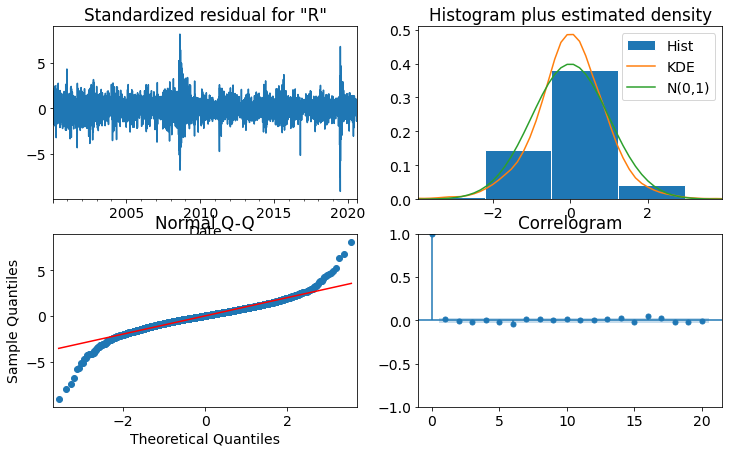

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(train_y, 
 exog=train_X,
 order=(0,0,5),
 trend = 'c')
 #enforce_invertibility=False, enforce_stationarity=False)
results= model.fit(method_kwargs={"warn_convergence": False})
results.summary()

results.plot_diagnostics(figsize = (12, 7), lags=20)
plt.savefig("High resoltion.png",dpi=300)

##### 6.4.2 indicadores de erro

/home/lneves/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


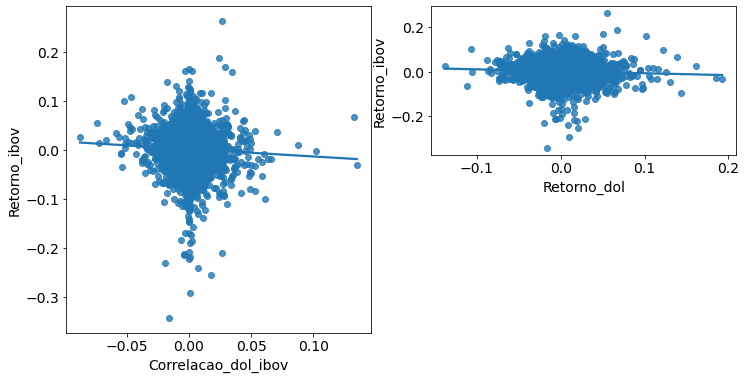

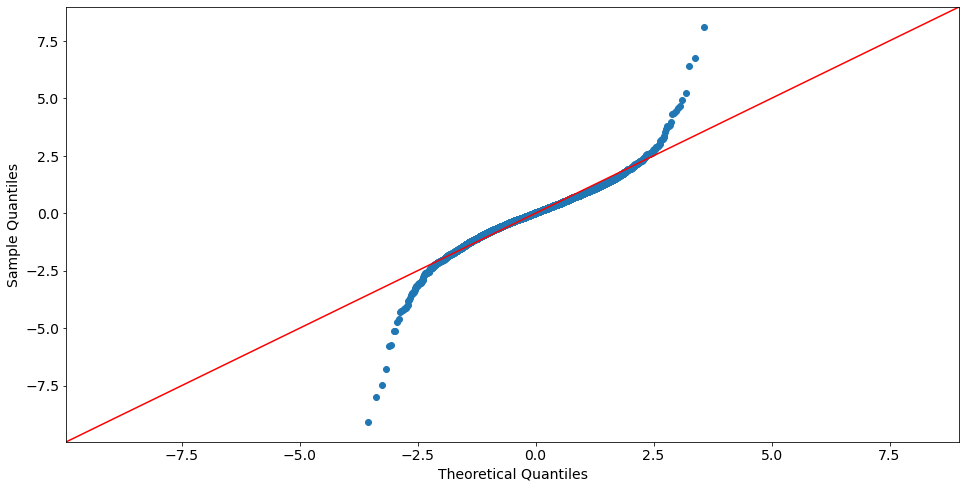

<AxesSubplot:xlabel='Date'>

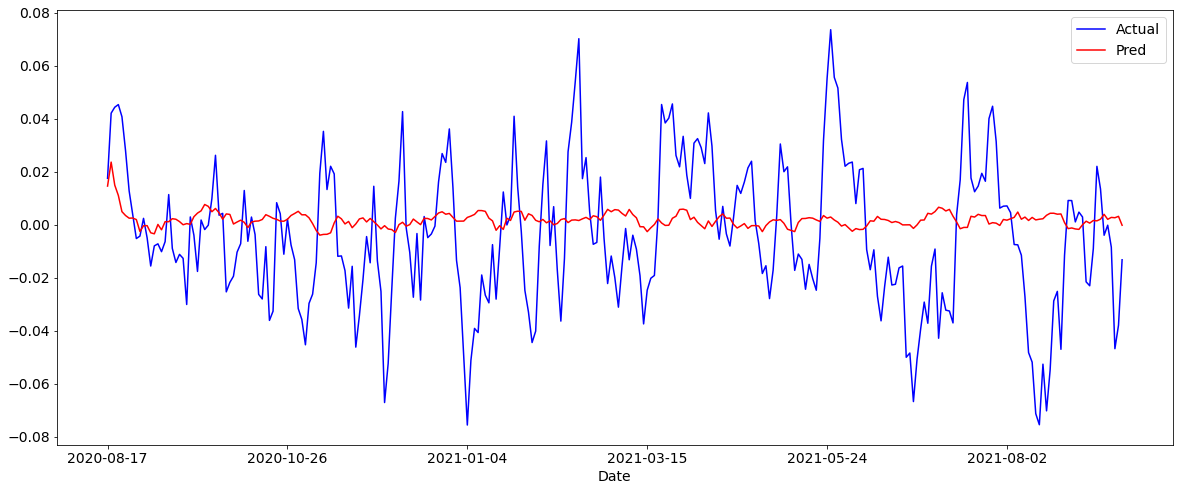

In [69]:
import statsmodels.api as sm

plt.figure(figsize = ((12, 6)))
plt.subplot(1, 2, 1)
y=df['Retorno_ibov']
x=df['Correlacao_dol_ibov']
sns.regplot(x, y, ci=None)
plt.subplot(1, 2, 2)
y=df['Retorno_ibov']
x=df['Retorno_dol']
plt.subplot(2, 2, 2)
sns.regplot(x, y, ci=None)
sm.qqplot(results.resid,line='45',fit=True)
plt.show()

steps = 0
predictions=results.predict(start=train_size,end=train_size+test_size+(steps)-1,exog=test_X)
forecast_1= results.forecast(steps=test_size, exog=test_X)
act= pd.DataFrame(y.iloc[train_size:, ])
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Pred2'] = pred_ses
predictions['Pred3'] = pred_holt
predictions['Actual'] = act['Retorno_ibov']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

In [70]:
def RMSE(Y_Predicted,Y_actual):
    rmse = np.sqrt(np.mean(((Y_actual - Y_Predicted)**2)))
    return rmse
def MAPE(Y_Predicted,Y_actual):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))
    return mape
def MAE(Y_Predicted,Y_actual):
    mae = np.mean(np.abs((Y_actual - Y_Predicted)))
    return mae

rmse=RMSE(predictions['Pred'], predictions['Actual'])
mape=MAPE(predictions['Pred'], predictions['Actual'])
mae=MAE(predictions['Pred'], predictions['Actual'])

rmse2=RMSE(predictions['Pred2'], predictions['Actual'])
mape2=MAPE(predictions['Pred2'], predictions['Actual'])
mae2=MAE(predictions['Pred2'], predictions['Actual'])

rmse3=RMSE(predictions['Pred3'], predictions['Actual'])
mape3=MAPE(predictions['Pred3'], predictions['Actual'])
mae3=MAE(predictions['Pred3'], predictions['Actual'])

print(["RMSE SARIMAX",rmse,"RMSE SUAV EXP",rmse2,"RMSE HOLT",rmse3])
print(["MAPE SARIMAX",mape,"MAPE SUAV EXP",mape2,"MAPE HOLT",mape3])
print(["MAE SARIMAX",mae,"MAE SUAV EXP",mae2,"MAE HOLT",mae3])


accuracy=np.mean(((predictions['Pred']>0)==(predictions['Actual']>0))|((predictions['Pred']<=0)==(predictions['Actual']<=0)))
print("Accuracy",accuracy)
confusion_matrix=pd.crosstab(predictions['Pred']>0, predictions['Actual']>0)
confusion_matrix

['RMSE SARIMAX', 0.027803180615499343, 'RMSE SUAV EXP', 0.03907397816650871, 'RMSE HOLT', 0.040324875673435796]
['MAPE SARIMAX', 2.1438949653225516, 'MAPE SUAV EXP', 13.480575720836871, 'MAPE HOLT', 14.57720066488985]
['MAE SARIMAX', 0.022332960734979177, 'MAE SUAV EXP', 0.03274350826277242, 'MAE HOLT', 0.03392524380176201]
Accuracy 0.3992932862190813


Actual,False,True
Pred,,
False,34,37
True,133,79
